# MIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit the **MIKH** model to LAOS data (nonlinear oscillatory response)
2. Analyze **Lissajous figures** (stress vs strain loops)
3. Extract **harmonic content** from the stress response
4. Understand the role of **plasticity** and **thixotropy** in nonlinear oscillatory response
5. Compare response at different frequencies

## Prerequisites

- NB01: MIKH Flow Curve (parameter understanding)
- NB05: MIKH SAOS (linear viscoelastic baseline)

## Runtime

- Fast demo: ~4-5 minutes
- Full run: ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import rfft, rfftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_laos,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: LAOS in Thixotropic Materials

Large Amplitude Oscillatory Shear (LAOS) probes the **nonlinear** viscoelastic and viscoplastic response.

### Applied Deformation

$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

where $\gamma_0 > \gamma_{yield}$ (large enough to induce plastic flow).

### Nonlinear Stress Response

The stress response contains **odd harmonics**:
$$
\sigma(t) = \sum_{n=1,3,5,...} [\sigma_n' \sin(n\omega t) + \sigma_n'' \cos(n\omega t)]
$$

### Key Nonlinear Features in MIKH

1. **Plastic yielding**: Distorts sinusoidal stress response
2. **Kinematic hardening**: Creates asymmetry in strain-stress loops
3. **Thixotropic restructuring**: Amplitude/frequency-dependent structure

### Lissajous Figures

Plotting $\sigma$ vs $\gamma$ reveals:
- **Ellipse**: Linear viscoelastic (SAOS)
- **Distorted ellipse**: Nonlinear viscoelastic
- **Rectangular**: Yield stress dominated

### Harmonic Analysis

The **third harmonic ratio** $I_3/I_1$ quantifies nonlinearity:
- $I_3/I_1 \to 0$: Linear response
- $I_3/I_1 > 0$: Nonlinear (strain stiffening or softening)

## 3. Load Data

We load LAOS data from the PNAS Digital Rheometer Twin dataset at $\omega = 1$ rad/s.

In [3]:
# Load LAOS data at omega = 1 rad/s, medium amplitude
omega = 1.0
strain_amp_idx = 8  # Medium-large amplitude

t_data, strain_data, stress_data = load_pnas_laos(omega=omega, strain_amplitude_index=strain_amp_idx)

# Estimate strain amplitude from data
gamma_0 = np.max(np.abs(strain_data))

print(f"LAOS data loaded:")
print(f"  omega = {omega} rad/s")
print(f"  gamma_0 = {gamma_0:.4f} (estimated)")
print(f"  Points: {len(t_data)}")
print(f"  Time range: [{t_data.min():.3f}, {t_data.max():.2f}] s")

LAOS data loaded:
  omega = 1.0 rad/s
  gamma_0 = 3.1599 (estimated)
  Points: 1000
  Time range: [0.005, 66.00] s


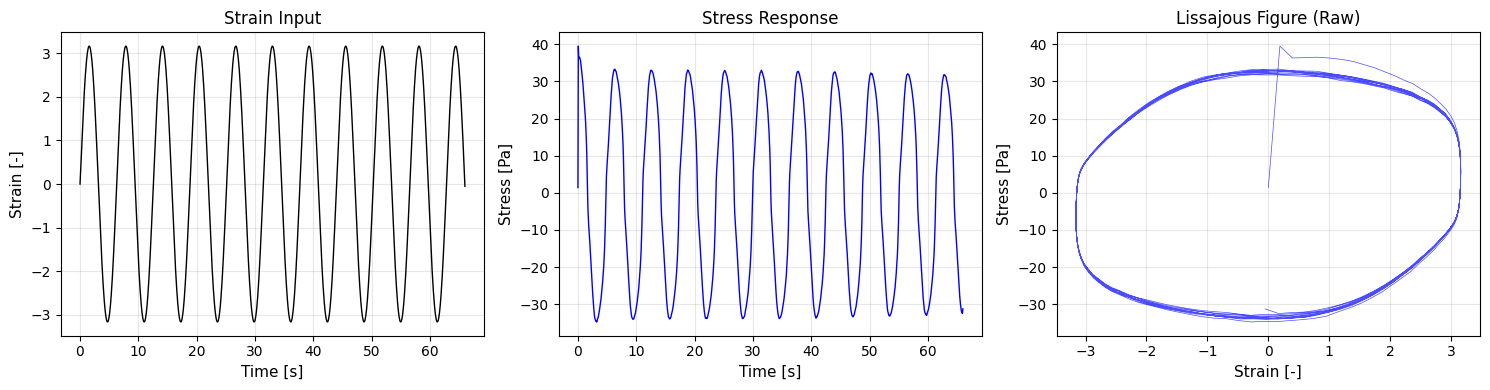

In [4]:
# Plot raw LAOS data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series - strain
axes[0].plot(t_data, strain_data, "k-", lw=1)
axes[0].set_xlabel("Time [s]", fontsize=11)
axes[0].set_ylabel("Strain [-]", fontsize=11)
axes[0].set_title("Strain Input", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Time series - stress
axes[1].plot(t_data, stress_data, "b-", lw=1)
axes[1].set_xlabel("Time [s]", fontsize=11)
axes[1].set_ylabel("Stress [Pa]", fontsize=11)
axes[1].set_title("Stress Response", fontsize=12)
axes[1].grid(True, alpha=0.3)

# Lissajous figure
axes[2].plot(strain_data, stress_data, "b-", lw=0.5, alpha=0.7)
axes[2].set_xlabel("Strain [-]", fontsize=11)
axes[2].set_ylabel("Stress [Pa]", fontsize=11)
axes[2].set_title("Lissajous Figure (Raw)", fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit MIKH model to LAOS data
model = MIKH()
param_names = get_mikh_param_names()

print(f"Fitting MIKH to LAOS data (gamma_0 = {gamma_0:.3f}, omega = {omega} rad/s)")
t0 = time.time()
model.fit(t_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

Fitting MIKH to LAOS data (gamma_0 = 3.160, omega = 1.0 rad/s)


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/mikh.py", line 454, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.28 s

Fitted parameters:
  G               = 1.384
  eta             = 5.567e+04
  C               = 369.3
  gamma_dyn       = 154.1
  m               = 1.007
  sigma_y0        = 6.792
  delta_sigma_y   = 37.32
  tau_thix        = 3606
  Gamma           = 2159
  eta_inf         = 10.89
  mu_p            = 0.001


In [6]:
# Predict and compute fit quality
stress_pred = model.predict(t_data, test_mode="laos",  gamma_0=gamma_0,  omega=omega)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   0.992365
  RMSE:  2.159 Pa


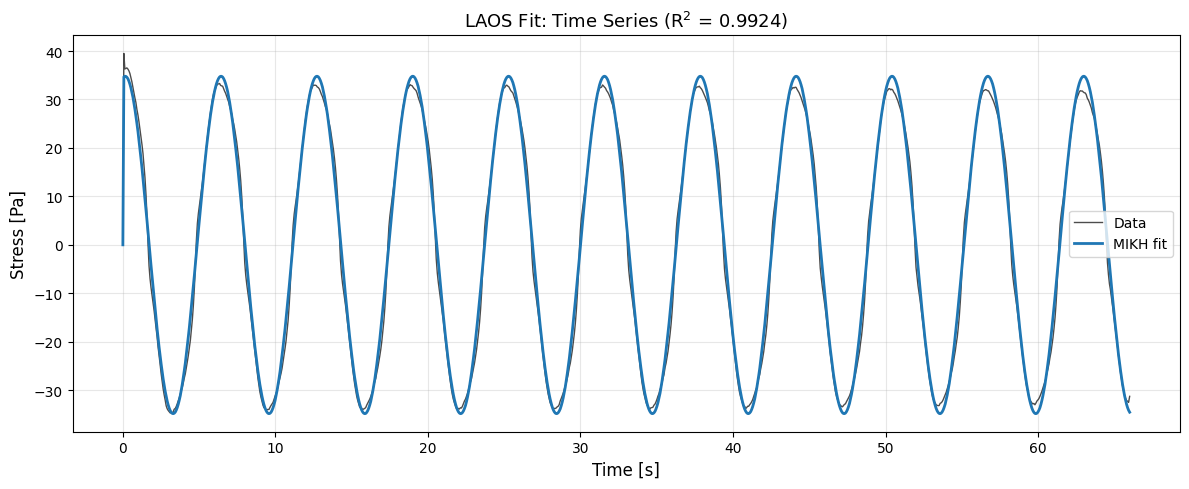

In [7]:
# Plot fit: time series
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(t_data, stress_data, "k-", lw=1, alpha=0.7, label="Data")
ax.plot(t_data, stress_pred, "-", lw=2, color="C0", label="MIKH fit")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"LAOS Fit: Time Series (R$^2$ = {metrics['R2']:.4f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

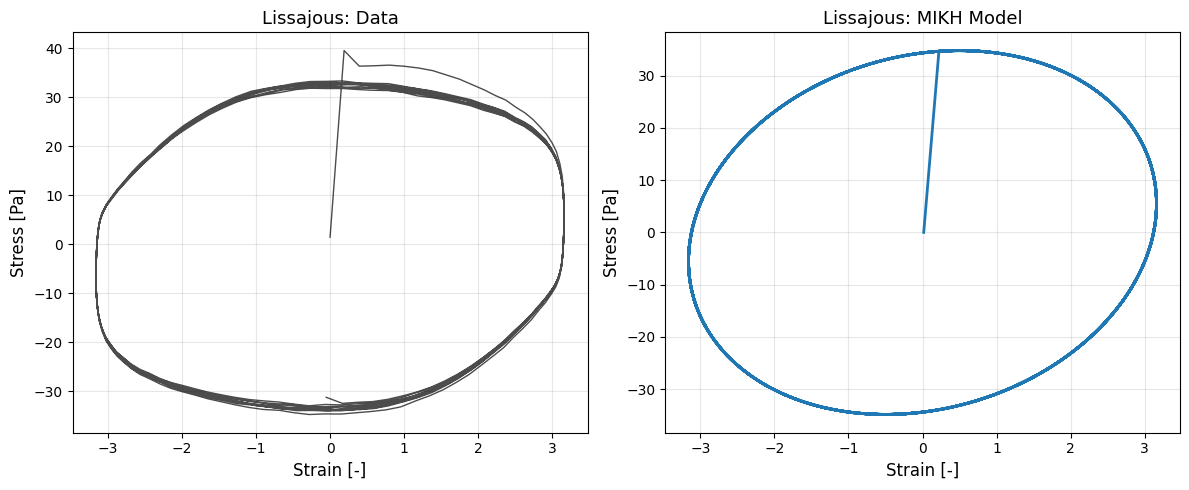

In [8]:
# Lissajous comparison
strain_pred = gamma_0 * np.sin(omega * np.array(t_data))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data Lissajous
ax1.plot(strain_data, stress_data, "k-", lw=1, alpha=0.7)
ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Lissajous: Data", fontsize=13)
ax1.grid(True, alpha=0.3)

# Model Lissajous
ax2.plot(strain_pred, stress_pred, "-", lw=2, color="C0")
ax2.set_xlabel("Strain [-]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Lissajous: MIKH Model", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Harmonic Analysis

In [9]:
# Extract harmonics via FFT
def extract_harmonics(t, y, omega, n_harmonics=5):
    """Extract harmonic amplitudes from oscillatory signal."""
    n = len(y)
    dt = np.mean(np.diff(t))
    
    # FFT
    Y = rfft(y)
    freqs = rfftfreq(n, dt)
    
    # Find fundamental frequency index
    f0 = omega / (2 * np.pi)
    idx_f0 = np.argmin(np.abs(freqs - f0))
    
    # Extract harmonic amplitudes
    harmonics = {}
    for h in range(1, n_harmonics + 1):
        idx = idx_f0 * h
        if idx < len(Y):
            harmonics[h] = 2 * np.abs(Y[idx]) / n
        else:
            harmonics[h] = 0.0
    
    return harmonics

# Extract harmonics from data and model
harmonics_data = extract_harmonics(t_data, stress_data, omega)
harmonics_model = extract_harmonics(t_data, np.array(stress_pred), omega)

print("Harmonic Analysis:")
print(f"{'Harmonic':<10} {'Data [Pa]':>12} {'Model [Pa]':>12}")
print("-" * 36)
for h in range(1, 6):
    print(f"  I_{h:<6}    {harmonics_data.get(h, 0):12.3f}   {harmonics_model.get(h, 0):12.3f}")

# Third harmonic ratio (nonlinearity measure)
I3_I1_data = harmonics_data.get(3, 0) / harmonics_data.get(1, 1)
I3_I1_model = harmonics_model.get(3, 0) / harmonics_model.get(1, 1)
print(f"\nThird harmonic ratio I_3/I_1:")
print(f"  Data:  {I3_I1_data:.4f}")
print(f"  Model: {I3_I1_model:.4f}")

Harmonic Analysis:
Harmonic      Data [Pa]   Model [Pa]
------------------------------------
  I_1               23.290         23.284
  I_2                1.421          1.296
  I_3                0.334          0.741
  I_4                0.467          0.527
  I_5                0.593          0.411

Third harmonic ratio I_3/I_1:
  Data:  0.0143
  Model: 0.0318


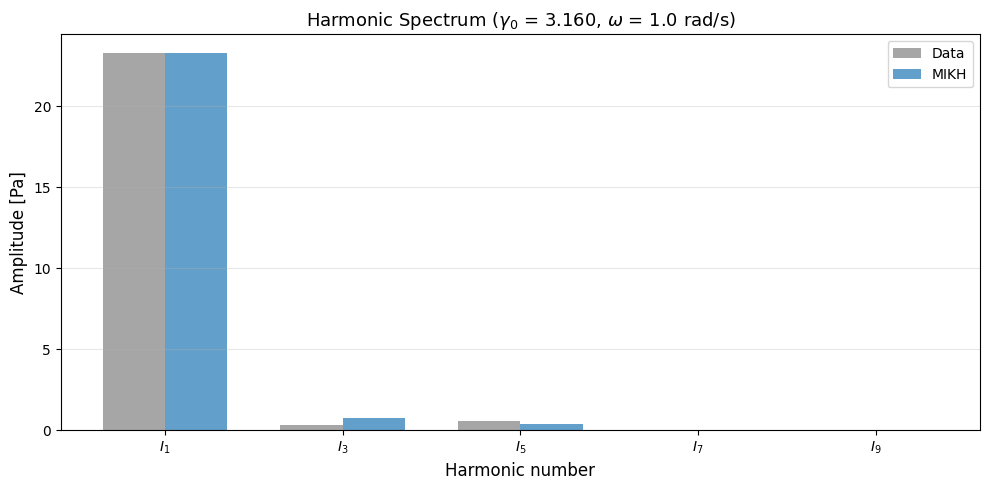

In [10]:
# Harmonic spectrum plot
fig, ax = plt.subplots(figsize=(10, 5))

harmonics = [1, 3, 5, 7, 9]
data_vals = [harmonics_data.get(h, 0) for h in harmonics]
model_vals = [harmonics_model.get(h, 0) for h in harmonics]

x = np.arange(len(harmonics))
width = 0.35

ax.bar(x - width/2, data_vals, width, label="Data", color="gray", alpha=0.7)
ax.bar(x + width/2, model_vals, width, label="MIKH", color="C0", alpha=0.7)

ax.set_ylabel("Amplitude [Pa]", fontsize=12)
ax.set_xlabel("Harmonic number", fontsize=12)
ax.set_title(f"Harmonic Spectrum ($\\gamma_0$ = {gamma_0:.3f}, $\\omega$ = {omega} rad/s)", fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([f"$I_{h}$" for h in harmonics])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Multi-Frequency Analysis

In [11]:
# Load LAOS at multiple frequencies (with fallback for missing data)
omega_values = [1.0, 3.0]  # omega=5.0 may not have data at all strain amplitudes
laos_datasets = {}

for w in omega_values:
    try:
        t, strain, stress = load_pnas_laos(omega=w, strain_amplitude_index=strain_amp_idx)
        if len(t) > 0 and len(strain) > 0:
            laos_datasets[w] = {"time": t, "strain": strain, "stress": stress}
            print(f"omega = {w} rad/s: {len(t)} points, gamma_0 ~ {np.max(np.abs(strain)):.3f}")
        else:
            print(f"omega = {w} rad/s: Empty data, skipping")
    except Exception as e:
        print(f"omega = {w} rad/s: Failed to load ({e})")

omega = 1.0 rad/s: 1000 points, gamma_0 ~ 3.160


omega = 3.0 rad/s: 1000 points, gamma_0 ~ 3.160


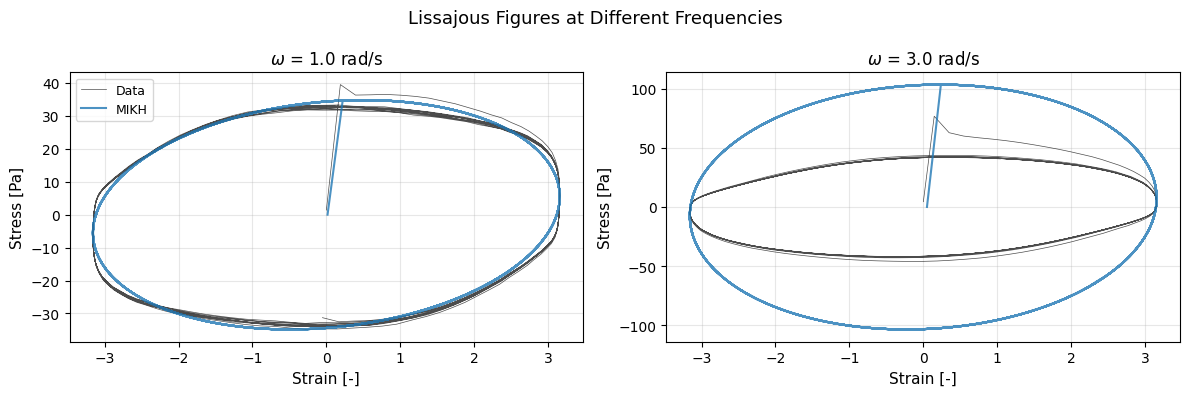

In [12]:
# Compare Lissajous figures at different frequencies
n_datasets = len(laos_datasets)
if n_datasets > 0:
    fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 4))
    if n_datasets == 1:
        axes = [axes]

    for i, w in enumerate(laos_datasets.keys()):
        d = laos_datasets[w]
        
        # Data
        axes[i].plot(d["strain"], d["stress"], "k-", lw=0.5, alpha=0.7, label="Data")
        
        # Model prediction
        gamma_0_w = np.max(np.abs(d["strain"]))
        stress_pred_w = model.predict(d["time"], test_mode="laos",  gamma_0=gamma_0_w,  omega=w)
        strain_pred_w = gamma_0_w * np.sin(w * np.array(d["time"]))
        axes[i].plot(strain_pred_w, stress_pred_w, "-", lw=1.5, color="C0", alpha=0.8, label="MIKH")
        
        axes[i].set_xlabel("Strain [-]", fontsize=11)
        axes[i].set_ylabel("Stress [Pa]", fontsize=11)
        axes[i].set_title(f"$\\omega$ = {w} rad/s", fontsize=12)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(fontsize=9)

    plt.suptitle("Lissajous Figures at Different Frequencies", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("No LAOS datasets available for multi-frequency comparison")

## 7. Bayesian Inference

In [13]:
# Bayesian inference (reduced for time-domain LAOS)
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 50   # Reduced for LAOS
NUM_SAMPLES = 100  # Reduced for LAOS
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print("(Note: Time-domain LAOS inference is slow, using reduced samples)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="laos",
    gamma_0=gamma_0,
    omega=omega,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
(Note: Time-domain LAOS inference is slow, using reduced samples)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:32,  1.61it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 5/150 [00:03<01:35,  1.52it/s, 1023 steps of size 8.98e-04. acc. prob=0.36]

warmup:   4%|▍         | 6/150 [00:05<02:37,  1.09s/it, 1023 steps of size 7.13e-04. acc. prob=0.47]

warmup:   5%|▍         | 7/150 [00:08<03:29,  1.46s/it, 1023 steps of size 6.28e-04. acc. prob=0.55]

warmup:   5%|▌         | 8/150 [00:11<04:14,  1.79s/it, 1023 steps of size 5.86e-04. acc. prob=0.60]

warmup:   6%|▌         | 9/150 [00:13<04:39,  1.98s/it, 1023 steps of size 5.74e-04. acc. prob=0.65]

warmup:   7%|▋         | 10/150 [00:16<05:00,  2.15s/it, 1023 steps of size 5.77e-04. acc. prob=0.68]

warmup:   7%|▋         | 11/150 [00:18<05:19,  2.30s/it, 1023 steps of size 6.02e-04. acc. prob=0.71]

warmup:   8%|▊         | 12/150 [00:21<05:25,  2.36s/it, 1023 steps of size 6.38e-04. acc. prob=0.73]

warmup:   9%|▊         | 13/150 [00:23<05:35,  2.45s/it, 1023 steps of size 6.87e-04. acc. prob=0.75]

warmup:   9%|▉         | 14/150 [00:26<05:41,  2.51s/it, 1023 steps of size 7.46e-04. acc. prob=0.77]

warmup:  10%|█         | 15/150 [00:29<05:43,  2.55s/it, 1023 steps of size 7.84e-04. acc. prob=0.79]

warmup:  11%|█         | 16/150 [00:31<05:44,  2.57s/it, 1023 steps of size 8.62e-04. acc. prob=0.80]

warmup:  11%|█▏        | 17/150 [00:34<05:45,  2.60s/it, 1023 steps of size 9.51e-04. acc. prob=0.81]

warmup:  12%|█▏        | 18/150 [00:37<05:37,  2.56s/it, 1023 steps of size 1.05e-03. acc. prob=0.82]

warmup:  13%|█▎        | 19/150 [00:39<05:39,  2.59s/it, 1023 steps of size 1.06e-03. acc. prob=0.83]

warmup:  13%|█▎        | 20/150 [00:42<05:35,  2.58s/it, 1023 steps of size 1.18e-03. acc. prob=0.84]

warmup:  14%|█▍        | 21/150 [00:44<05:34,  2.60s/it, 1023 steps of size 1.30e-03. acc. prob=0.85]

warmup:  15%|█▍        | 22/150 [00:47<05:34,  2.61s/it, 1023 steps of size 1.42e-03. acc. prob=0.85]

warmup:  15%|█▌        | 23/150 [00:50<05:32,  2.62s/it, 1023 steps of size 1.52e-03. acc. prob=0.86]

warmup:  16%|█▌        | 24/150 [00:52<05:27,  2.60s/it, 1023 steps of size 1.61e-03. acc. prob=0.86]

warmup:  17%|█▋        | 25/150 [00:55<05:28,  2.63s/it, 1023 steps of size 1.78e-03. acc. prob=0.87]

warmup:  17%|█▋        | 26/150 [00:58<05:24,  2.62s/it, 1023 steps of size 1.84e-03. acc. prob=0.87]

warmup:  18%|█▊        | 27/150 [01:00<05:18,  2.59s/it, 1023 steps of size 2.02e-03. acc. prob=0.88]

warmup:  19%|█▊        | 28/150 [01:03<05:22,  2.64s/it, 1023 steps of size 2.11e-03. acc. prob=0.88]

warmup:  19%|█▉        | 29/150 [01:05<05:18,  2.64s/it, 1023 steps of size 1.70e-03. acc. prob=0.88]

warmup:  20%|██        | 30/150 [01:08<05:15,  2.63s/it, 1023 steps of size 1.59e-03. acc. prob=0.88]

warmup:  21%|██        | 31/150 [01:11<05:10,  2.61s/it, 1023 steps of size 1.75e-03. acc. prob=0.89]

warmup:  21%|██▏       | 32/150 [01:13<05:14,  2.66s/it, 1023 steps of size 1.92e-03. acc. prob=0.89]

warmup:  22%|██▏       | 33/150 [01:16<05:09,  2.64s/it, 1023 steps of size 2.12e-03. acc. prob=0.89]

warmup:  23%|██▎       | 34/150 [01:19<05:06,  2.65s/it, 1023 steps of size 2.30e-03. acc. prob=0.90]

warmup:  23%|██▎       | 35/150 [01:21<05:01,  2.62s/it, 1023 steps of size 2.41e-03. acc. prob=0.90]

warmup:  24%|██▍       | 36/150 [01:24<04:59,  2.63s/it, 1023 steps of size 1.64e-03. acc. prob=0.90]

warmup:  25%|██▍       | 37/150 [01:26<04:55,  2.62s/it, 1023 steps of size 1.76e-03. acc. prob=0.90]

warmup:  25%|██▌       | 38/150 [01:29<04:55,  2.64s/it, 1023 steps of size 1.81e-03. acc. prob=0.90]

warmup:  26%|██▌       | 39/150 [01:32<04:49,  2.61s/it, 1023 steps of size 1.86e-03. acc. prob=0.90]

warmup:  27%|██▋       | 40/150 [01:34<04:45,  2.60s/it, 1023 steps of size 2.04e-03. acc. prob=0.91]

warmup:  27%|██▋       | 41/150 [01:37<04:51,  2.67s/it, 1023 steps of size 1.46e-03. acc. prob=0.90]

warmup:  28%|██▊       | 42/150 [01:40<04:45,  2.64s/it, 1023 steps of size 1.59e-03. acc. prob=0.91]

warmup:  29%|██▊       | 43/150 [01:42<04:40,  2.63s/it, 1023 steps of size 1.71e-03. acc. prob=0.91]

warmup:  29%|██▉       | 44/150 [01:45<04:42,  2.67s/it, 1023 steps of size 1.86e-03. acc. prob=0.91]

warmup:  30%|███       | 45/150 [01:48<04:37,  2.65s/it, 1023 steps of size 1.93e-03. acc. prob=0.91]

warmup:  31%|███       | 46/150 [01:50<04:33,  2.63s/it, 1023 steps of size 1.97e-02. acc. prob=0.91]

warmup:  31%|███▏      | 47/150 [01:51<03:21,  1.95s/it, 127 steps of size 2.02e-02. acc. prob=0.92] 

warmup:  32%|███▏      | 48/150 [01:51<02:38,  1.56s/it, 255 steps of size 2.09e-02. acc. prob=0.92]

warmup:  33%|███▎      | 49/150 [01:52<01:59,  1.18s/it, 127 steps of size 2.16e-02. acc. prob=0.92]

warmup:  33%|███▎      | 50/150 [01:52<01:32,  1.08it/s, 127 steps of size 2.13e-02. acc. prob=0.92]

sample:  34%|███▍      | 51/150 [01:52<01:13,  1.36it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  35%|███▍      | 52/150 [01:52<00:59,  1.63it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  35%|███▌      | 53/150 [01:53<00:52,  1.86it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  36%|███▌      | 54/150 [01:54<00:55,  1.73it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  37%|███▋      | 55/150 [01:54<00:56,  1.67it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  37%|███▋      | 56/150 [01:54<00:48,  1.96it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  38%|███▊      | 57/150 [01:55<00:37,  2.45it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  39%|███▊      | 58/150 [01:55<00:43,  2.11it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  39%|███▉      | 59/150 [01:56<00:48,  1.86it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  40%|████      | 60/150 [01:56<00:42,  2.12it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  41%|████      | 61/150 [01:56<00:33,  2.63it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  41%|████▏     | 62/150 [01:57<00:31,  2.78it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  42%|████▏     | 63/150 [01:57<00:30,  2.85it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  43%|████▎     | 64/150 [01:57<00:29,  2.93it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  43%|████▎     | 65/150 [01:58<00:36,  2.31it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  44%|████▍     | 66/150 [01:59<00:49,  1.69it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  45%|████▍     | 67/150 [01:59<00:42,  1.96it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  45%|████▌     | 68/150 [02:00<00:48,  1.69it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  46%|████▌     | 69/150 [02:01<00:55,  1.46it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  47%|████▋     | 70/150 [02:01<00:46,  1.73it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  47%|████▋     | 71/150 [02:02<00:39,  2.00it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  48%|████▊     | 72/150 [02:02<00:38,  2.02it/s, 191 steps of size 2.13e-02. acc. prob=1.00]

sample:  49%|████▊     | 73/150 [02:02<00:34,  2.25it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  49%|████▉     | 74/150 [02:03<00:27,  2.78it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  50%|█████     | 75/150 [02:03<00:25,  2.91it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  51%|█████     | 76/150 [02:04<00:31,  2.34it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  51%|█████▏    | 77/150 [02:04<00:35,  2.03it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  52%|█████▏    | 78/150 [02:05<00:32,  2.25it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  53%|█████▎    | 79/150 [02:05<00:28,  2.45it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  53%|█████▎    | 80/150 [02:05<00:26,  2.66it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  54%|█████▍    | 81/150 [02:06<00:25,  2.68it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  55%|█████▍    | 82/150 [02:06<00:31,  2.19it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  55%|█████▌    | 83/150 [02:07<00:35,  1.91it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  56%|█████▌    | 84/150 [02:08<00:38,  1.72it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  57%|█████▋    | 85/150 [02:08<00:32,  2.00it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  57%|█████▋    | 86/150 [02:08<00:28,  2.26it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  58%|█████▊    | 87/150 [02:09<00:25,  2.48it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  59%|█████▊    | 88/150 [02:09<00:29,  2.09it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  59%|█████▉    | 89/150 [02:10<00:27,  2.24it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  60%|██████    | 90/150 [02:10<00:24,  2.42it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  61%|██████▏   | 92/150 [02:10<00:18,  3.19it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  62%|██████▏   | 93/150 [02:11<00:22,  2.57it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  63%|██████▎   | 94/150 [02:11<00:24,  2.24it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  63%|██████▎   | 95/150 [02:12<00:22,  2.42it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  64%|██████▍   | 96/150 [02:12<00:20,  2.61it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  65%|██████▍   | 97/150 [02:12<00:19,  2.73it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  65%|██████▌   | 98/150 [02:13<00:18,  2.86it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  66%|██████▌   | 99/150 [02:13<00:17,  2.98it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  67%|██████▋   | 100/150 [02:14<00:21,  2.36it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  67%|██████▋   | 101/150 [02:14<00:23,  2.07it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  68%|██████▊   | 102/150 [02:15<00:25,  1.85it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  69%|██████▊   | 103/150 [02:16<00:26,  1.77it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  69%|██████▉   | 104/150 [02:16<00:28,  1.59it/s, 319 steps of size 2.13e-02. acc. prob=1.00]

sample:  70%|███████   | 105/150 [02:17<00:28,  1.59it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  71%|███████   | 106/150 [02:18<00:31,  1.38it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  71%|███████▏  | 107/150 [02:18<00:23,  1.81it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  72%|███████▏  | 108/150 [02:19<00:22,  1.88it/s, 191 steps of size 2.13e-02. acc. prob=1.00]

sample:  73%|███████▎  | 109/150 [02:19<00:19,  2.14it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  73%|███████▎  | 110/150 [02:19<00:15,  2.66it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  74%|███████▍  | 111/150 [02:19<00:13,  2.84it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  75%|███████▍  | 112/150 [02:20<00:12,  2.97it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  75%|███████▌  | 113/150 [02:20<00:12,  2.96it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  76%|███████▌  | 114/150 [02:20<00:11,  3.03it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  77%|███████▋  | 115/150 [02:22<00:21,  1.67it/s, 511 steps of size 2.13e-02. acc. prob=1.00]

sample:  77%|███████▋  | 116/150 [02:22<00:17,  1.94it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  78%|███████▊  | 117/150 [02:23<00:21,  1.55it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  79%|███████▊  | 118/150 [02:23<00:20,  1.58it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  79%|███████▉  | 119/150 [02:24<00:20,  1.54it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  80%|████████  | 120/150 [02:24<00:14,  2.00it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  81%|████████  | 121/150 [02:25<00:18,  1.55it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  81%|████████▏ | 122/150 [02:25<00:14,  1.95it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  82%|████████▏ | 123/150 [02:26<00:17,  1.53it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  83%|████████▎ | 124/150 [02:27<00:16,  1.54it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  83%|████████▎ | 125/150 [02:27<00:14,  1.79it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  84%|████████▍ | 126/150 [02:28<00:16,  1.48it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  85%|████████▍ | 127/150 [02:29<00:17,  1.33it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  85%|████████▌ | 128/150 [02:30<00:13,  1.62it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  86%|████████▌ | 129/150 [02:30<00:11,  1.85it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  87%|████████▋ | 130/150 [02:30<00:09,  2.07it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  87%|████████▋ | 131/150 [02:30<00:07,  2.55it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  88%|████████▊ | 132/150 [02:31<00:06,  2.68it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  89%|████████▊ | 133/150 [02:31<00:06,  2.72it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  89%|████████▉ | 134/150 [02:31<00:05,  2.83it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  90%|█████████ | 135/150 [02:32<00:06,  2.30it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  91%|█████████ | 136/150 [02:33<00:06,  2.06it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  91%|█████████▏| 137/150 [02:33<00:05,  2.27it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  92%|█████████▏| 138/150 [02:34<00:06,  2.00it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  93%|█████████▎| 139/150 [02:34<00:04,  2.23it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  93%|█████████▎| 140/150 [02:34<00:04,  2.44it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  94%|█████████▍| 141/150 [02:35<00:03,  2.57it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  95%|█████████▍| 142/150 [02:35<00:03,  2.16it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  95%|█████████▌| 143/150 [02:36<00:03,  1.94it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  96%|█████████▌| 144/150 [02:37<00:03,  1.83it/s, 255 steps of size 2.13e-02. acc. prob=1.00]

sample:  97%|█████████▋| 145/150 [02:37<00:03,  1.53it/s, 383 steps of size 2.13e-02. acc. prob=1.00]

sample:  97%|█████████▋| 146/150 [02:38<00:02,  1.79it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  98%|█████████▊| 147/150 [02:38<00:01,  2.27it/s, 63 steps of size 2.13e-02. acc. prob=1.00] 

sample:  99%|█████████▊| 148/150 [02:38<00:00,  2.46it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample:  99%|█████████▉| 149/150 [02:39<00:00,  2.62it/s, 127 steps of size 2.13e-02. acc. prob=1.00]

sample: 100%|██████████| 150/150 [02:40<00:00,  1.49it/s, 511 steps of size 2.13e-02. acc. prob=1.00]

sample: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it, 511 steps of size 2.13e-02. acc. prob=1.00]


Bayesian inference time: 163.6 s


In [14]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       100     CHECK
            eta    1.0000       100     CHECK
              C    1.0000       100     CHECK
      gamma_dyn    1.0000       100     CHECK
              m    1.0000       100     CHECK
       sigma_y0    1.0000       100     CHECK
  delta_sigma_y    1.0000       100     CHECK
       tau_thix    1.0000       100     CHECK
          Gamma    1.0000       100     CHECK
        eta_inf    1.0000       100     CHECK
           mu_p    1.0000       100     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


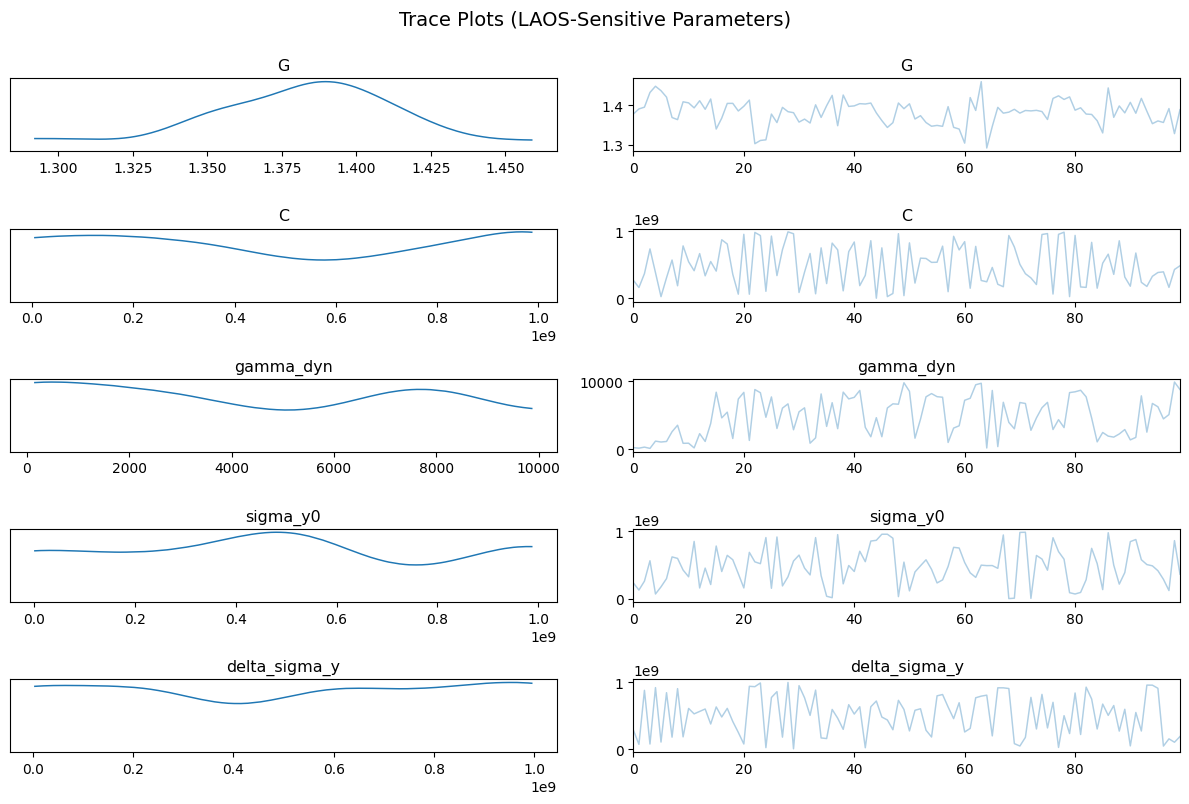

In [15]:
# Trace plots
idata = result.to_inference_data()
laos_params = ["G", "C", "gamma_dyn", "sigma_y0", "delta_sigma_y"]
axes = az.plot_trace(idata, var_names=laos_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (LAOS-Sensitive Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

In [16]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         1.384         1.385  [1.307, 1.44]
            eta     5.567e+04     4.592e+11  [4.002e+10, 9.496e+11]
              C         369.3      4.21e+08  [2.744e+07, 9.719e+08]
      gamma_dyn         154.1          4604  [213.2, 9589]
              m         1.007          1.29  [0.6721, 2.665]
       sigma_y0         6.792     4.886e+08  [9.854e+06, 9.707e+08]
  delta_sigma_y         37.32     5.362e+08  [2.206e+07, 9.558e+08]
       tau_thix          3606      4.94e+11  [9.618e+09, 9.547e+11]
          Gamma          2159          5298  [292, 9763]
        eta_inf         10.89          10.9  [10.83, 10.95]
           mu_p         0.001         499.3  [49.76, 928]


## 8. Physical Interpretation

### Lissajous Shape Analysis

The shape of the Lissajous figure reveals the material character:

- **Narrow ellipse**: Elastic-dominated
- **Wide ellipse**: Viscous-dominated
- **Rectangular**: Yield stress dominated (rate-independent plasticity)
- **Parallelogram**: Kinematic hardening present

### Nonlinearity Sources in MIKH

1. **Plastic flow**: When $|\sigma - \alpha| > \sigma_y$, creates distortion
2. **Kinematic hardening**: Backstress $\alpha$ shifts yield surface during cycle
3. **Thixotropic dynamics**: Structure varies within cycle at low frequencies

### Frequency Dependence

- **Low frequency** ($\omega \ll 1/\tau_{thix}$): Full thixotropic restructuring within cycle
- **High frequency** ($\omega \gg 1/\tau_{thix}$): Structure frozen, pure elastoplastic response

## 9. Save Results

In [17]:
# Save results
save_ikh_results(model, result, "mikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/laos/
  nlsq_params_laos.json: 11 parameters
  posterior_laos.json: 100 draws


## Key Takeaways

1. **LAOS** probes the nonlinear mechanical response of MIKH materials beyond the yield stress

2. **Lissajous figures** reveal the interplay of elasticity, viscosity, and plasticity

3. **Harmonic analysis** quantifies nonlinearity through $I_3/I_1$ and higher harmonics

4. **Kinematic hardening** ($C$, $\gamma_{dyn}$) creates asymmetry in the stress-strain loops

5. **Frequency dependence**: Low $\omega$ allows thixotropic restructuring; high $\omega$ freezes structure

6. The MIKH model captures the essential LAOS features through its elastoplastic + thixotropic framework

### Next Steps (MLIKH Notebooks)

- **NB07**: MLIKH Flow Curve (multi-mode thixotropic yield)
- **NB08**: MLIKH Startup (richer overshoot dynamics)
- **NB09-12**: MLIKH for remaining protocols